# Case Study: Sliding-window glass event detection
构造长音频（背景床 + glass 混入），滑窗推理并做事件级评估。


## 导入与配置
设置路径、模型、混音与评估参数（集中于 config）。


In [1]:
import json
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import soundfile as sf
import torch

sys.path.append('src')

from src.config import (
    SR,
    TARGET_LABELS,
    WINDOW_HOP,
    WINDOW_SECONDS,
    CASE_STUDY_DEFAULTS,
    CASE_STUDY_DIR,
    CASE_STUDY_SCHEMA_VERSION,
    CASE_STUDY_META_FILES,
    HARD_BG_CLASSES,
    HARD_BG_WEIGHT,
    SEED,
    PROJECT_ROOT,
)
from src.event_detection import (
    ClipSpec,
    GLASS_LABEL,
    build_background_bed,
    mix_glass_on_bed,
    sliding_log_mel_windows,
    merge_events,
    match_events,
    match_events_with_pairs,
    bucket_recall_by_snr,
    bucket_delay,
    predict_label_probs,
    smooth_probabilities,
)
from src.inference import create_onnx_session, load_torch_checkpoint
from src.meta_utils import load_meta_files, map_canonical_labels
import matplotlib.pyplot as plt
import librosa


In [2]:
# Defaults and paths
params = {**CASE_STUDY_DEFAULTS}
RNG_SEED = params.get('rng_seed', SEED)
CASE_STUDY_DIR.mkdir(parents=True, exist_ok=True)
RUN_CONFIG_PATH = CASE_STUDY_DIR / 'run_config.json'
MIX_PATH = CASE_STUDY_DIR / 'mix.wav'
TARGET_BED_DURATION = params['target_bed_duration']
BACKGROUND_GAIN_DB = params.get('background_gain_db', CASE_STUDY_DEFAULTS.get('background_gain_db', -8.0))
GLASS_GAIN_DB = params.get('glass_gain_db', CASE_STUDY_DEFAULTS.get('glass_gain_db', 0.0))
START_OFFSET_RANGE = params['start_offset_range']
GAP_RANGE = params['gap_range']
SNR_RANGE_DB = params['snr_range_db']
CROSSFADE_MS = params['crossfade_ms']
SPLIT_TOP_DB = params['split_top_db']
MIN_EVENT_DUR = params['min_event_dur']
THRESHOLD = params.get('threshold', 0.7)
MERGE_GAP = params['merge_gap']
TOLERANCE = params['tolerance']
SMOOTH_K = int(params.get('smooth_k', 1) or 1)
BACKGROUND_ONLY = bool(params.get('background_only', False))


## 保存本次运行配置
记录混音/评估参数，便于复现与比较。


In [3]:
run_config = {
    'schema': CASE_STUDY_SCHEMA_VERSION,
    'params': params,
    'rng_seed': RNG_SEED,
    'mix_path': str(MIX_PATH),
    'meta_files': [str(p) for p in CASE_STUDY_META_FILES],
}
RUN_CONFIG_PATH.write_text(json.dumps(run_config, indent=2))
print(f'Saved config to {RUN_CONFIG_PATH}')


Saved config to /workspace/cache/mel64/case_study/run_config.json


## 收集片段并准备背景床
加载外部 glass 片段，采样多段背景，拼接 ~60s 背景床。


In [4]:
# Collect positive clips (all TARGET_LABELS) and background pool from meta
META_FILES = CASE_STUDY_META_FILES
meta_df = load_meta_files(META_FILES)
meta_df = map_canonical_labels(meta_df, label_map={}, target_labels=TARGET_LABELS)

# Positives: sample up to 5 per label to limit length
pos_specs = []
for lab in TARGET_LABELS:
    sub = meta_df[meta_df['canonical_label'] == lab]
    if sub.empty:
        continue
    take = min(5, len(sub))
    for _, row in sub.sample(n=take, random_state=SEED).iterrows():
        p = Path(row['filepath'])
        if not p.is_absolute():
            p = PROJECT_ROOT / p
        pos_specs.append(ClipSpec(path=p, label=lab, gain_db=GLASS_GAIN_DB))

# Background pool excludes target labels
bg_df = meta_df[~meta_df['canonical_label'].isin(TARGET_LABELS)]
if bg_df.empty:
    raise RuntimeError('No background clips available; check meta files')
bg_specs = []
for _, row in bg_df.sample(n=min(50, len(bg_df)), random_state=SEED).iterrows():
    p = Path(row['filepath'])
    if not p.is_absolute():
        p = PROJECT_ROOT / p
    bg_specs.append(ClipSpec(path=p, label='background', gain_db=BACKGROUND_GAIN_DB))
print(f'Pos specs: {len(pos_specs)} across labels {TARGET_LABELS} | BG pool: {len(bg_specs)}')


Pos specs: 10 across labels ['glass', 'gunshot'] | BG pool: 50


## 构造背景床 (约 60s)
将背景片段交叉淡入淡出拼接成底床。


In [5]:
background_bed = build_background_bed(
    bg_specs,
    sr=SR,
    target_duration=TARGET_BED_DURATION,
    crossfade_ms=CROSSFADE_MS,
    normalize=True,
)
print(f'Background bed duration: {len(background_bed)/SR:.2f}s')


Background bed duration: 80.00s


## 叠加 glass 事件并切分真值
随机顺序与间隔叠加 glass，自动检测片段内的有效击碎段作为真值。


In [6]:
rng = np.random.default_rng(RNG_SEED)
if BACKGROUND_ONLY:
    audio = background_bed
    gt_events = []
else:
    audio, gt_events = mix_glass_on_bed(
        background_bed,
        pos_specs,
        sr=SR,
        start_offset_range=START_OFFSET_RANGE,
        gap_range=GAP_RANGE,
        crossfade_ms=CROSSFADE_MS,
        snr_range_db=SNR_RANGE_DB,
        split_top_db=SPLIT_TOP_DB,
        min_event_dur=MIN_EVENT_DUR,
        max_event_dur=params.get('max_event_dur', None),
        seed=None,
        rng=rng,
    )
sf.write(MIX_PATH, audio, SR)

# keep raw GT before filtering
gt_events_raw = gt_events


## 生成滑窗 mel 批次
使用训练同参 (1s/0.5s) 转换为 log-mel。


In [7]:
batch, spans = sliding_log_mel_windows(
    audio,
    sr=SR,
    window_seconds=WINDOW_SECONDS,
    hop_seconds=WINDOW_HOP,
    min_coverage=0.7,
)
print(f"Windows: {len(spans)}, batch shape: {tuple(batch.shape)}")


Windows: 159, batch shape: (159, 1, 64, 87)


## Torch 与 ONNX 推理
批量前向得到每窗 glass 概率，并比对 Torch/ONNX，随后可选平滑。


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt_path = Path('cache/experiments/tinyglassnet_best.pt')
onnx_path = Path('cache/experiments/tinyglassnet_best.onnx')

model, _ = load_torch_checkpoint(ckpt_path, device=device)
probs_dict, _ = predict_label_probs(batch, spans, labels=TARGET_LABELS, model=model, device=device)

onnx_probs = None
if onnx_path.exists():
    onnx_sess = create_onnx_session(onnx_path)
    onnx_probs, _ = predict_label_probs(batch, spans, labels=TARGET_LABELS, session=onnx_sess, device='cpu')

torch_probs_smooth = {lab: smooth_probabilities(probs, kernel_size=SMOOTH_K) for lab, probs in probs_dict.items()}
pred_events = {}
metrics = {}
pairs_dict = {}
unmatched_gt = {}
unmatched_pred = {}
snr_recalls = {}
delay_buckets = {}
for lab in TARGET_LABELS:
    gt_lab = [ev for ev in gt_events if ev.label == lab]
    prob_lab = torch_probs_smooth.get(lab, [])
    pred_lab = merge_events(spans, prob_lab, threshold=THRESHOLD, merge_gap=MERGE_GAP)
    pred_events[lab] = pred_lab
    metrics[lab] = match_events(pred_lab, gt_lab, tolerance=TOLERANCE)
    pairs, u_gt, u_pred = match_events_with_pairs(pred_lab, gt_lab, tolerance=TOLERANCE)
    pairs_dict[lab] = pairs
    unmatched_gt[lab] = u_gt
    unmatched_pred[lab] = u_pred
    matched_gt_indices = [gt_lab.index(gt) for gt, _, _ in pairs]
    snr_recalls[lab] = bucket_recall_by_snr(gt_lab, matched_gt_indices)
    delay_buckets[lab] = bucket_delay(pairs)


## GT 审查与忽略列表
切分更细后，可人工试听并将需忽略的 GT 写入列表。


In [9]:
# 审查前的 GT 备份
if 'gt_events_raw' not in globals():
    gt_events_raw = gt_events

IGNORE_EVENTS = [
    # 示例: ("glass_ext_01", 29.01, 29.57),
]
IGNORE_TOL = 0.1  # seconds tolerance

from IPython.display import Audio, display

print(f"Total GT raw: {len(gt_events_raw)}")

def should_ignore(ev):
    for src, s, e in IGNORE_EVENTS:
        if ev.source == src and ev.start >= s - IGNORE_TOL and ev.end <= e + IGNORE_TOL:
            return True
    return False

gt_events = [ev for ev in gt_events_raw if not should_ignore(ev)]
print(f"GT after ignore: {len(gt_events)}")

# 可选：试听所有 GT 片段（混音中的片段）
for i, ev in enumerate(gt_events):
    seg = audio[int(ev.start * SR): int(ev.end * SR)]
    print(f"GT#{i} {ev.source}: {ev.start:.2f}-{ev.end:.2f}s")
    display(Audio(seg, rate=SR))


Total GT raw: 15
GT after ignore: 15
GT#0 3 (7): 4.69-5.03s


GT#1 3 (7): 5.15-6.15s


GT#2 3 (7): 6.15-6.69s


GT#3 5 (50): 8.09-9.09s


GT#4 glass_ext_09: 12.98-13.67s


GT#5 7 (9): 20.95-21.95s


GT#6 7 (9): 21.95-22.35s


GT#7 glass_ext_01: 28.47-28.93s


GT#8 glass_ext_01: 30.98-31.42s


GT#9 glass_ext_07: 37.98-38.28s


GT#10 glass_ext_10: 46.51-46.86s


GT#11 6 (35): 53.76-54.76s


GT#12 6 (35): 54.76-55.76s


GT#13 glass_ext_03: 65.37-66.09s


GT#14 9 (35): 74.84-75.84s


## 合并窗口并评估事件（含分桶）
阈值合并窗口，允许 ±0.5s 偏移匹配，输出 P/R/F1，并按 SNR/延迟分桶。


In [ ]:
# Metrics summary per label
for lab in TARGET_LABELS:
    m = metrics.get(lab, {})
    tp = m.get('tp', 0); fp = m.get('fp', 0); fn = m.get('fn', 0)
    prec = m.get('precision', 0.0); rec = m.get('recall', 0.0); f1 = m.get('f1', 0.0)
    pred_n = len(pred_events.get(lab, []))
    gt_n = len([ev for ev in gt_events if ev.label == lab])
    acc = tp / (tp + fp + fn + 1e-8)
    print(f'=== {lab} ===')
    print('gt={gt_n} pred={pred_n} tp={tp} fp={fp} fn={fn} acc={acc:.3f} precision={prec:.3f} recall={rec:.3f} f1={f1:.3f}'.format(        gt_n=gt_n, pred_n=pred_n, tp=tp, fp=fp, fn=fn, acc=acc, prec=prec, rec=rec, f1=f1))
    print(f'Unmatched GT: {unmatched_gt.get(lab, [])}')
    print(f'Unmatched Pred: {unmatched_pred.get(lab, [])}')
    print(f'SNR buckets: {snr_recalls.get(lab, {})}')
    print(f'Delay buckets: {delay_buckets.get(lab, {})}
')


## 概率时间轴可视化
画出平滑后的概率柱状并标记 GT 与预测事件。


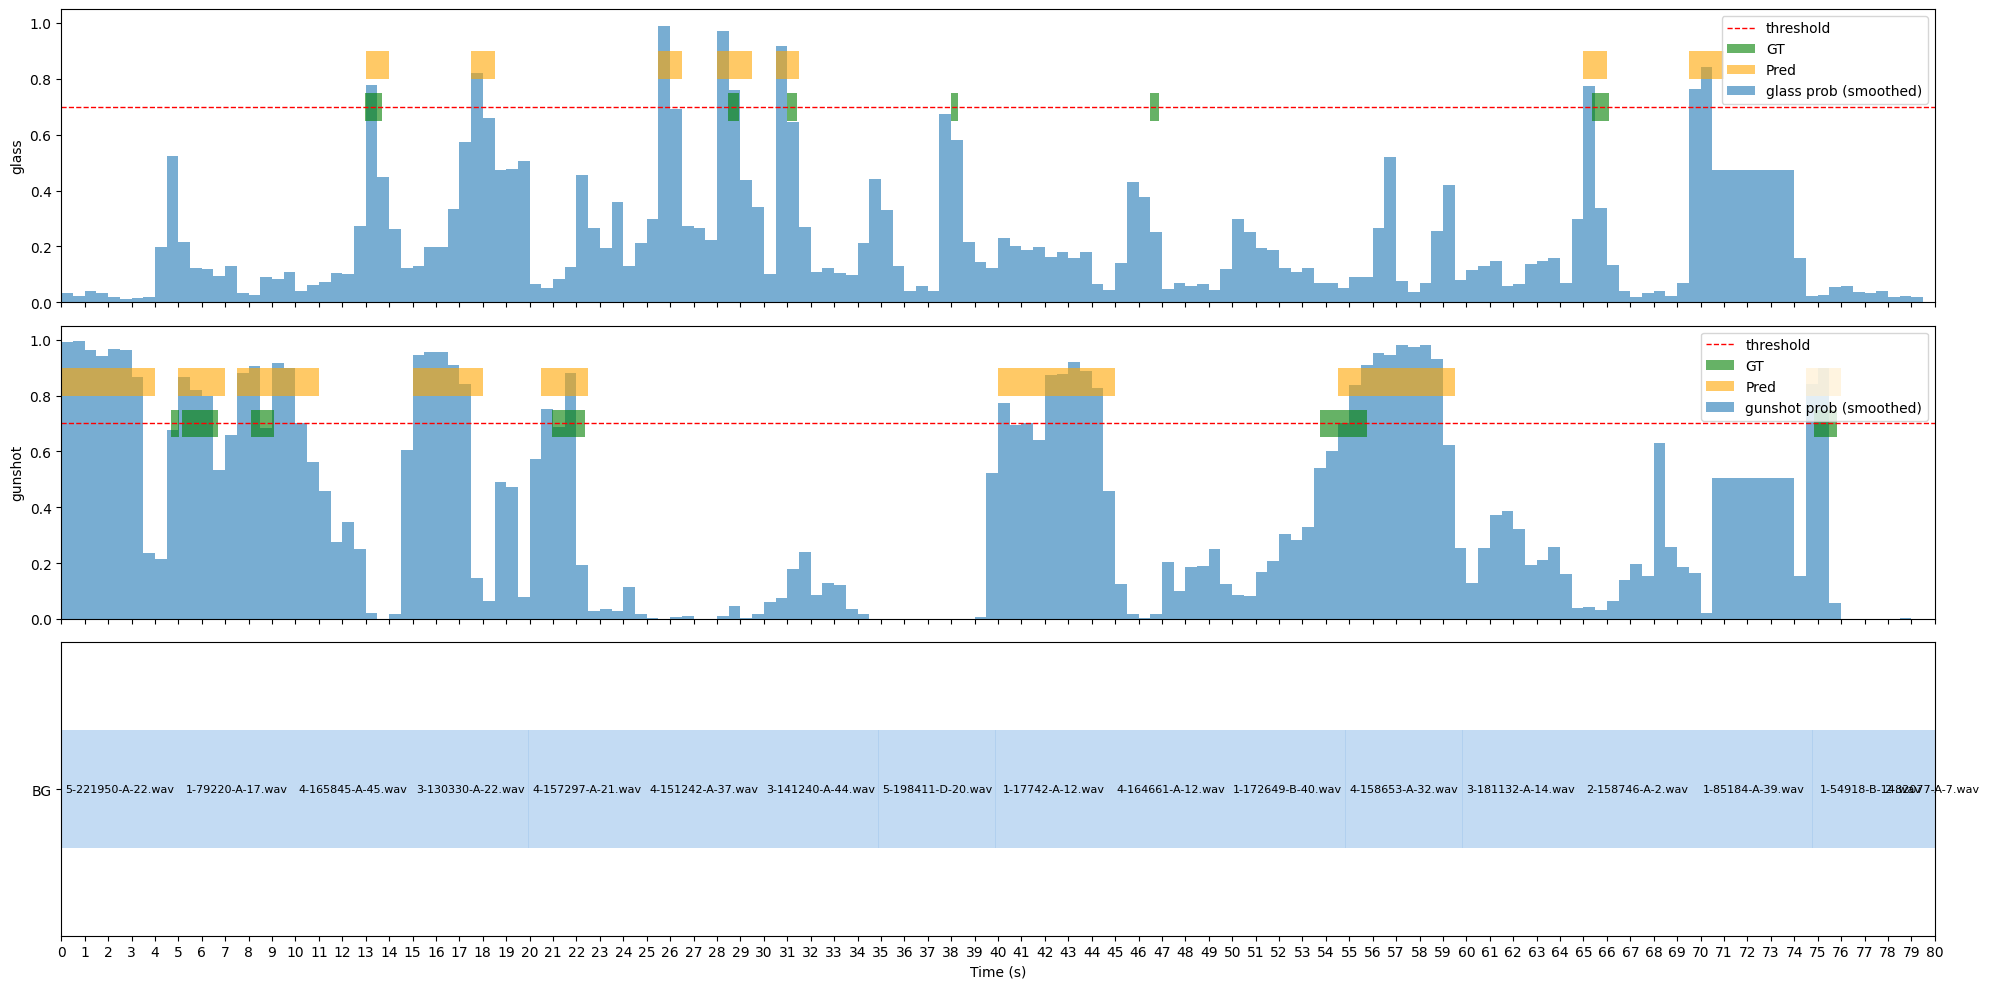

In [11]:
import matplotlib.pyplot as plt
import librosa
import numpy as np

rows = len(TARGET_LABELS) + 1
fig, axes = plt.subplots(rows, 1, figsize=(20, 6 + 2*len(TARGET_LABELS)), sharex=True)
if rows == 1:
    axes = [axes]
starts = [s for s, _ in spans]
for idx, lab in enumerate(TARGET_LABELS):
    ax = axes[idx]
    probs = torch_probs_smooth.get(lab, [])
    ax.bar(starts, probs, width=WINDOW_HOP, align='edge', alpha=0.6, label=f'{lab} prob (smoothed)')
    ax.axhline(THRESHOLD, color='red', linestyle='--', linewidth=1, label='threshold')
    gt_lab = [(ev.start, ev.end - ev.start) for ev in gt_events if ev.label == lab]
    pred_lab = [(ev['start'], ev['end'] - ev['start']) for ev in pred_events.get(lab, [])]
    ax.broken_barh(gt_lab, (0.65, 0.1), facecolors='green', alpha=0.6, label='GT')
    ax.broken_barh(pred_lab, (0.8, 0.1), facecolors='orange', alpha=0.6, label='Pred')
    ax.set_ylabel(lab)
    ax.set_ylim(0, 1.05)
    ax.legend(loc='upper right')

ax_b = axes[-1]
bg_spans = []
cursor = 0.0
crossfade_s = CROSSFADE_MS / 1000.0
bed_limit = len(background_bed) / SR
for spec in bg_specs:
    y, _ = librosa.load(spec.path, sr=SR)
    dur = len(y) / SR
    start = cursor
    end = start + dur
    if start >= bed_limit:
        break
    bg_spans.append((start, min(dur, bed_limit - start), spec.path.name))
    cursor = end - crossfade_s

for (start, dur, name) in bg_spans:
    ax_b.broken_barh([(start, dur)], (0.3, 0.4), facecolors='#aaccee', alpha=0.7)
    ax_b.text(start + dur / 2, 0.5, name, ha='center', va='center', fontsize=8)
ax_b.set_ylim(0, 1)
ax_b.set_yticks([0.5])
ax_b.set_yticklabels(['BG'])
ax_b.set_xlabel('Time (s)')
max_time = spans[-1][1] if spans else bed_limit
xticks = np.arange(0, max(max_time, bed_limit) + 1, 1)
ax_b.set_xticks(xticks)
for ax in axes:
    ax.set_xlim(0, max(max_time, bed_limit))

plt.tight_layout()


## 试听混音并查看真值时间
播放拼接后的长音频，并列出每个 glass 片段的起止时间。


In [12]:
from IPython.display import Audio, display

meta_lookup = {Path(row['filepath']).name: row['canonical_label'] for _, row in meta_df.iterrows()}

print(f"Mix duration: {len(audio)/SR:.2f}s (saved at {MIX_PATH})")
print('Ground truth glass events:')
for ev in gt_events:
    snr_txt = f" (SNR={ev.snr_db:.1f}dB)" if ev.snr_db is not None else ''
    print(f"  - {ev.source}: {ev.start:.2f}-{ev.end:.2f}s{snr_txt}")

display(Audio(str(MIX_PATH), rate=SR))

print('Background segments (mix order, clipped to bed length):')
bed_limit = len(background_bed) / SR
elapsed = 0.0
crossfade_s = CROSSFADE_MS / 1000.0
for spec in bg_specs:
    if elapsed >= bed_limit:
        break
    y, _ = librosa.load(spec.path, sr=SR)
    dur = len(y) / SR
    start = elapsed
    end = start + dur
    if end > bed_limit:
        end = bed_limit
    if start >= bed_limit:
        break
    cat = meta_lookup.get(spec.path.name, '?')
    print(f"  {spec.path.name} ({cat}): {start:.2f}-{end:.2f}s")
    elapsed = end - crossfade_s
    if end >= bed_limit:
        break


Mix duration: 80.00s (saved at /workspace/cache/mel64/case_study/mix.wav)
Ground truth glass events:
  - 3 (7): 4.69-5.03s (SNR=7.9dB)
  - 3 (7): 5.15-6.15s (SNR=7.9dB)
  - 3 (7): 6.15-6.69s (SNR=7.9dB)
  - 5 (50): 8.09-9.09s (SNR=6.3dB)
  - glass_ext_09: 12.98-13.67s (SNR=8.6dB)
  - 7 (9): 20.95-21.95s (SNR=8.1dB)
  - 7 (9): 21.95-22.35s (SNR=8.1dB)
  - glass_ext_01: 28.47-28.93s (SNR=5.1dB)
  - glass_ext_01: 30.98-31.42s (SNR=5.1dB)
  - glass_ext_07: 37.98-38.28s (SNR=4.3dB)
  - glass_ext_10: 46.51-46.86s (SNR=7.2dB)
  - 6 (35): 53.76-54.76s (SNR=5.8dB)
  - 6 (35): 54.76-55.76s (SNR=5.8dB)
  - glass_ext_03: 65.37-66.09s (SNR=8.5dB)
  - 9 (35): 74.84-75.84s (SNR=5.0dB)


Background segments (mix order, clipped to bed length):
  5-221950-A-22.wav (clapping): 0.00-5.00s
  1-79220-A-17.wav (pouring_water): 4.99-9.98s
  4-165845-A-45.wav (train): 9.97-14.97s
  3-130330-A-22.wav (clapping): 14.95-19.95s
  4-157297-A-21.wav (sneezing): 19.94-24.94s
  4-151242-A-37.wav (clock_alarm): 24.92-29.92s
  3-141240-A-44.wav (engine): 29.91-34.91s
  5-198411-D-20.wav (crying_baby): 34.89-39.89s
  1-17742-A-12.wav (crackling_fire): 39.88-44.88s
  4-164661-A-12.wav (crackling_fire): 44.86-49.86s
  1-172649-B-40.wav (helicopter): 49.85-54.85s
  4-158653-A-32.wav (keyboard_typing): 54.83-59.83s
  3-181132-A-14.wav (chirping_birds): 59.82-64.82s
  2-158746-A-2.wav (pig): 64.80-69.80s
  1-85184-A-39.wav (glass_breaking): 69.79-74.79s
  1-54918-B-14.wav (chirping_birds): 74.77-79.77s
  2-82077-A-7.wav (insects): 79.76-80.00s


## 事件级混淆矩阵 (overlap 即算命中)


In [18]:
# Metrics summary per label
for lab in TARGET_LABELS:
    m = metrics.get(lab, {})
    tp = m.get('tp', 0); fp = m.get('fp', 0); fn = m.get('fn', 0)
    prec = m.get('precision', 0.0); rec = m.get('recall', 0.0); f1 = m.get('f1', 0.0)
    pred_n = len(pred_events.get(lab, []))
    gt_n = len([ev for ev in gt_events if ev.label == lab])
    acc = tp / (tp + fp + fn + 1e-8)
    print(f'\n=== {lab} ===')
    print('gt={gt_n} pred={pred_n} tp={tp} fp={fp} fn={fn} acc={acc:.3f} precision={prec:.3f} recall={rec:.3f} f1={f1:.3f}'.format(
        gt_n=gt_n, pred_n=pred_n, tp=tp, fp=fp, fn=fn, acc=acc, prec=prec, rec=rec, f1=f1))
    print(f'Unmatched GT: {unmatched_gt.get(lab, [])}')
    print(f'Unmatched Pred: {unmatched_pred.get(lab, [])}')
    print(f'SNR buckets: {snr_recalls.get(lab, {})}')
    print(f'Delay buckets: {delay_buckets.get(lab, {})}')




=== glass ===
gt=6 pred=7 tp=4 fp=3 fn=2 acc=0.444 precision=0.571 recall=0.667 f1=0.615
Unmatched GT: [3, 4]
Unmatched Pred: [1, 2, 6]
SNR buckets: {'<5': 0.0, '5-8': 0.6666666666666666, '>8': 1.0}
Delay buckets: {'<0.25': 4, '0.25-0.5': 0, '>0.5': 0}

=== gunshot ===
gt=9 pred=8 tp=5 fp=3 fn=4 acc=0.417 precision=0.625 recall=0.556 f1=0.588
Unmatched GT: [1, 2, 5, 7]
Unmatched Pred: [0, 3, 5]
SNR buckets: {'<5': 1.0, '5-8': 0.5, '>8': 0.5}
Delay buckets: {'<0.25': 2, '0.25-0.5': 0, '>0.5': 3}
